[Back to manual](../karta-manual.html)

[Back to introduction](../introduction.html)

# Karta tutorial


## Introduction

*Karta* provides a set of tools for analysing geographical data. The organization of *Karta* is around a set of classes for representing vector and raster data. These classes contain built-in methods for common tasks, and are easily extended for more specialized processing. This tutorial provides a brief introduction to the elements of *Karta*.

Should you come across any mistakes, please file a bug or submit a pull request on [Github](https://github.com/fortyninemaps/karta)!

The following examples are shown using Python 3, however *Karta* is supported on Python 2.7+ and Python 3.4+.

## Definitions

**Vector data** are data that can be treated as a set of connected or disconnected vertices. Examples might be road networks, a set of borders, geophysical survey lines, or the path taken by a bottle floating in an ocean current. In *Karta*, these data are classified as belonging to *Point*, *Line* and *Polygon* classes, and their *Multipart* equivalents *Multipoint*, *Multiline*, and *Multipolygon*. Some questions that might be asked
of vector data include

- which of these points are contained in this Polygon?
- do these Lines intersect, and where?
- what is the average distance travelled by a particle?
- what municipalities does this river flow through?

**Raster data** is data that are typically thought of in terms of pixels or a grid of values covering a surface. Examples might be an elevation model, a satellite image, or an upstream area map. Depending on what the data represents, one might

- compute slope, aspect, and hillshades on an elevation model
- resample or interpolate a grid
- mask a land cover map according to management boundaries
- apply a pansharpening algorithm to multispectral satellite imagery
- extract an elevation profile along a path

The term **coordinate reference system** refers to a system of relating numerical coordinates to actual positions on Earth. *Karta* includes methods for geodetic calculations and basic support of projected and geographical coordinates, as well as coordinate system classes backed by *pyproj*.

## Vector data

This section demonstrates the creation and manipulation of vector data.

In [1]:
from karta import Point, Line, Polygon, Multipoint, Multiline, Multipolygon

The `Point`, `Line`, and `Polygon` classes can all be instantiated by providing vertices, and optionally, associated properties. The *Multipart* `Multipoint`, `Multiline`, and `Multipolygon` classes are similar, and can additionally include part-specific tabular metadata.

In [2]:
pt = Point((-123.1, 49.25))
print(pt)

Point(-123.1, 49.25)


In [3]:
mpt = Multipoint([(-122.93, 48.62),
                  (-123.10, 48.54),
                  (-122.90, 48.49),
                  (-122.81, 48.56)],
                 data={"color": ["red", "blue", "green", "yellow"],
                       "value": [2, 1, 3, 5]})
print(mpt)
print(mpt.data)

D[color, value]


In [4]:
line = Line([(-124.35713, 49.31437),
             (-124.37857, 49.31720),
             (-124.39442, 49.31833),
             (-124.40311, 49.31942),
             (-124.41052, 49.32203),
             (-124.41681, 49.32477),
             (-124.42278, 49.32588)])
print(line)

In [5]:
poly = Polygon([(-25.41, 67.03),
                (-24.83, 62.92),
                (-12.76, 63.15),
                (-11.44, 66.82)])
print(poly)

Each geometrical object now contains a vertex/vertices in a cartesian plane.

We may be interested in determining whether the `Point` created about is within the `Polygon`:

In [6]:
print(poly.contains(pt))       # False

False


In [7]:
# but this one is:
pt2 = Point((-25, 65))
print(poly.contains(pt2))      # True

True


We also can test whether the `Line` from above crosses the `Polygon`:

In [8]:
print(line.intersects(poly))   # False

False


Or compute the shortest distance between the `Point` and the `Line`:

In [9]:
print(line.shortest_distance_to(pt))

1.2587769197915923


There are methods for computing the nearest vertex to an external point, or the nearest point on an edge to an external point:

In [10]:
pt = Point((0.0, 60.0))
print(poly.nearest_vertex_to(pt))
print(poly.nearest_on_boundary(pt))

2
Point(-12.301580009598124, 64.42454648846582)


The positions of objects with multiple vertices can be sliced and iterated through:

In [11]:
subline = line[2:-2]
print(subline)

for pt in subline:
    print(pt)

Point(-124.39442, 49.31833)
Point(-124.40311, 49.31942)
Point(-124.41052, 49.32203)


A slice that takes part of a polygon returns a line.

In [12]:
print(poly[:2])

Points have a `distance()` method that calculates the distance to another point.

In [13]:
pt = Point((-123.1, 49.25))
pt2 = Point((-70.66, 41.52))
print(pt.distance(pt2))

53.00666467530286


By default, geometries in Karta use a planar cartesian coordinate system. If our positions are meant to be geographical coordinates, then we can provide the `crs` argument to each geometry at creation, as in

In [14]:
from karta.crs import LonLatWGS84

pt = Point((-123.1, 49.25), crs=LonLatWGS84)
pt2 = Point((-70.66, 41.52), crs=LonLatWGS84)
pt.distance(pt2)

4109559.5877279844

which now gives the great circle distance between point on the Earth, in meters. We can mix coordinate systems to some degree, with *Karta* performing the necessary transformations in the background:

In [15]:
from karta.crs import WebMercator

pt_web = Point((-14000000, 6300000), crs=WebMercator)
print(pt.distance(pt_web))   # distance in coordinate system units of *pt*

194483.5977009545


When the coordinate system is specified, all geometrical methods obey that coordinate system. We can use this to perform queries, such which American state capitols are within 2000 km of Mexico City?

In [16]:
from karta.examples import us_capitols
mexico_city = Point((-99.13, 19.43), crs=LonLatWGS84)

# Filter those within 2000 km of Mexico City
nearby = list(filter(lambda pt: pt.distance(mexico_city) < 2000e3, us_capitols))
for capitol in nearby:
    print("{0:4.0f} km      {1}".format(mexico_city.distance(capitol)/1e3, capitol.properties["n"]))

1785 km      Oklahoma City, Oklahoma, United States
1923 km      Montgomery, Alabama, United States
1822 km      Little Rock, Arkansas, United States
1933 km      Tallahassee, Florida, United States
1463 km      Baton Rouge, Louisiana, United States
1683 km      Jackson, Mississippi, United States
1922 km      Santa Fe, New Mexico, United States
1213 km      Austin, Texas, United States


In [17]:
# Or, list capitols from nearest to furthest from Mexico City
distances = map(lambda pt: mexico_city.distance(pt), us_capitols)
distances_capitols = sorted(zip(distances, us_capitols))
for d, pt in distances_capitols:
    print("{km:.0f} km      {name}".format(km=d/1e3, name=pt.properties["n"]))

1213 km      Austin, Texas, United States
1463 km      Baton Rouge, Louisiana, United States
1683 km      Jackson, Mississippi, United States
1785 km      Oklahoma City, Oklahoma, United States
1822 km      Little Rock, Arkansas, United States
1922 km      Santa Fe, New Mexico, United States
1923 km      Montgomery, Alabama, United States
1933 km      Tallahassee, Florida, United States
2027 km      Phoenix, Arizona, United States
2155 km      Atlanta, Georgia, United States
2199 km      Topeka, Kansas, United States
2214 km      Nashville, Tennessee, United States
2225 km      Jefferson City, Missouri, United States
2320 km      Denver, Colorado, United States
2382 km      Lincoln, Nebraska, United States
2414 km      Columbia, South Carolina, United States
2429 km      Springfield, Illinois, United States
2467 km      Cheyenne, Wyoming, United States
2495 km      Frankfort, Kentucky, United States
2510 km      Des Moines, Iowa, United States
2576 km      Indianapolis, Indiana, United

All of the above calculations are performed on a geoid. The `LonLatWGS84` coordinate system means to use geographical (longitude and latitude) coordinates on the WGS 84 ellipsoid.

### Associated data

By using the `data` keyword argument, additional data can be associated with a *Multipart* vector geometry. The data can be a list or a dictionary of lists.

In [18]:
mp = Multipoint([(1, 1), (3, 1), (4, 3), (2, 2)],
                data={"species": ["T. officianale", "C. tectorum",
                                  "M. alba", "V. cracca"]})

These data live in the `.data` attribute, which is a `Table` instance. For convenience, the data can also be accessed via the `.d` attribute, which provides a streamlined syntax supporting key-lookups, indexing, and slicing.

In [19]:
mp.d

Indexer(D[species])

In [20]:
mp.d["species"]

['T. officianale', 'C. tectorum', 'M. alba', 'V. cracca']

In [21]:
mp.d[1:3]

{'species': ['C. tectorum', 'M. alba']}

The data are propagated through indexing operations on their parent geometry:

In [22]:
pt = mp[2]
print(pt, "-", pt.properties["species"])

Point(4.0, 3.0) - M. alba


Geometry-level metadata at the geometry level can be provided using the `properties` keyword argument, which accepts a dictionary. Derived geometries carry the properties of their parent geometry.

In [23]:
poly = Polygon([(-25.41, 67.03),
                (-24.83, 62.92),
                (-12.76, 63.15),
                (-11.44, 66.82)],
               properties={"geology": "volcanic",
                           "alcohol": "brennivin"})
print(poly[0:3].properties)

{'geology': 'volcanic', 'alcohol': 'brennivin'}


### Visualizing and importing/exporting data

The `get_coordinate_lists` method and `coordinates` attribute provide lists of coordinates for plotting or data export.

Higher-level plotting operations are provided by the separate [`karta.plotting`](https://github.com/fortyninemaps/karta-map) submodule, not described here.

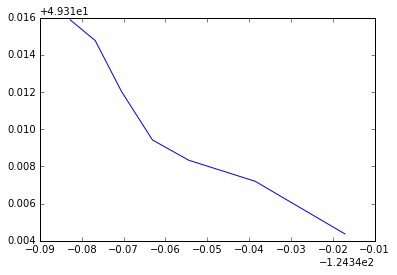

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(*line.coordinates)

Data can be read from and written to several common formats, including ESRI shapefiles (through bindings to the *pyshp* module), GeoJSON, and GPX. Convenience functions are kept in the `karta.vector.read` namespace.

Each geometry has appropriate methods to write data:

In [25]:
line.to_shapefile("line.shp")
pt_web.to_geojson("point.geojson")

## Raster data

Raster data are primarily represented by the `karta.RegularGrid` class. `RegularGrid` instances have a CRS, a Null-data value, a geotransform, and one or more *bands*, which containing the actual data.

### Bands

To provide flexibility, different band classes are provided by `karta.raster.bands` using different strategies for data storage.

- The simplest case, `SimpleBand`, uses a numpy array to store all data. This makes it reasonably fast, but can be memory-hungry with large rasters.
- The default case, `CompressedBand`, uses chunking and compression via the *blosc* library to reduce the memory footprint of the raster data at a small speed cost.
- `GdalFileBand` reads data directly from a valid GDAL datasource, using the least memory but performing the slowest.

> Note: `GdalFileBand` doesn't currently handle all raster operations supported by the other band types. Many operations implicitly convert to in-memory `CompressedBand` representation.

In [26]:
import numpy as np
from karta.raster import RegularGrid, SimpleBand, CompressedBand, read_gtiff

ls8 = read_gtiff("LC80080032016087LGN00_B2.TIF")
print(ls8.bands)     # list of one CompressedBand instance

In [27]:
# Print grid dimensions
print(ls8.size)

(9141, 9151)


In [28]:
# Print grid extent
print(ls8.extent)

(354000.0, 628500.0, 8648400.0, 8922600.0)


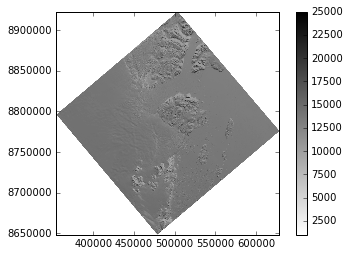

In [29]:
# Visualize data
plt.imshow(ls8[::10,::10], origin="bottom", extent=ls8.extent, cmap=plt.cm.binary, vmin=1e3, vmax=25e3)
plt.colorbar()

When opening or creating a `RegularGrid`, a non-default band type can be specified as a keyword argument. The following code re-opens the same grid as a `SimpleBand` and verifies that all data are the same.

In [30]:
ls8_numpy = read_gtiff("LC80080032016087LGN00_B2.TIF", bandclass=SimpleBand)
np.all(ls8[:,:] == ls8_numpy[:,:])    # True

True

In the above, the slice syntax `[:,:]` is used to get an array of all grid data. Because the grid `ls8` has only a single band in this case, the data array has two dimensions. The normal simple slicing rules apply, i.e. one can do things like:

In [31]:
subgrid = ls8[2000:3000, 4000:4500]
print(subgrid.shape)

(1000, 500)


In [32]:
every_other = ls8[::2, ::2]
print(every_other.shape)

(4571, 4576)


In [33]:
ls8.transform

(353985.0, 8648385.0, 30.0, 30.0, 0.0, -0.0)

Grid geolocation is based on an affine matrix transformation represented by the `.transform` attribute, as well as an associated coordinate system under the `.crs` attribute. The extent and bounding box of the grid can be retrieved using the repsective properties:

In [34]:
print(ls8.bbox)
print(ls8.extent)

(353985.0, 8648385.0, 628515.0, 8922615.0)
(354000.0, 628500.0, 8648400.0, 8922600.0)


The `extent` is of the form *(xmin, xmax, ymin, xmax)*, and refers to grid centers. The `bbox` is of the form *(xmin, ymin, xmax, ymax)*, and refers to grid edges.

To get swaths of grid coordinates conveniently and in arbitrary coordinate systems, used the `.coordinates()` method, which returns a `CoordinateGenerator` instance that can be indexed to generate coordinate pairs.

In [35]:
coords = ls8.coordinates(crs=LonLatWGS84)
print(coords[0,0])
print(coords[-1,-1])
print(coords[:5,:5])

(-27.22064150950398, 77.84116697331031)
(-27.221774740799813, 77.8408712597137)
(array([[-27.22064151, -27.22077667, -27.22091183, -27.221047  ,
        -27.22118218],
       [-27.21937309, -27.21950822, -27.21964336, -27.2197785 ,
        -27.21991365],
       [-27.21810467, -27.21823977, -27.21837488, -27.21851   ,
        -27.21864512],
       [-27.21683624, -27.21697132, -27.2171064 , -27.21724149,
        -27.21737658],
       [-27.21556781, -27.21570286, -27.21583791, -27.21597297,
        -27.21610804]]), array([[ 77.84116697,  77.84143421,  77.84170145,  77.84196868,
         77.84223592],
       [ 77.84119545,  77.84146268,  77.84172992,  77.84199716,
         77.84226439],
       [ 77.84122391,  77.84149115,  77.84175839,  77.84202562,
         77.84229286],
       [ 77.84125237,  77.84151961,  77.84178685,  77.84205409,
         77.84232132],
       [ 77.84128083,  77.84154807,  77.8418153 ,  77.84208254,
         77.84234978]]))


### Grid sampling

*Nearest-neighbour* and *bilinear* sampling of grid points is supported via the `.sample()` method. It is also possible to resample the full grid at a new resolution, or to sample along a profile.

In [36]:
val = ls8.sample(Point((500000, 8750000), crs=ls8.crs))     # sample a point using the grid CRS
print(val)

[[13701]]


In [37]:
# Resample grid at 100 m postings:
ls8_coarse = ls8.resample(100, 100)
print("Original resolution:", ls8.resolution)
print("Resampled resolution:", ls8_coarse.resolution)

Original resolution: (30.0, 30.0)
Resampled resolution: (100.0, 100.0)


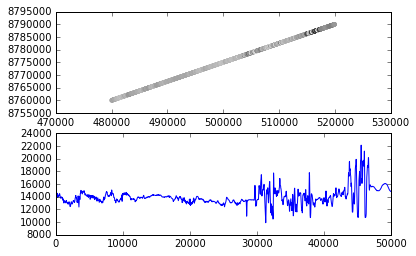

In [38]:
# Generate a line and sample at intervals along it
transit = Line(zip(np.linspace(480000, 520000), np.linspace(8760000, 8790000)), crs=ls8.crs)
mp, val = ls8.profile(transit)

plt.subplot(2, 1, 1)
x, y = mp.coordinates
plt.scatter(x, y, c=val, edgecolor="none", cmap=plt.cm.binary)

plt.subplot(2, 1, 2)
dist = Line(mp).cumulength()    # convert sample points to a line and extract
                                # the cumulative distance along it
plt.plot(dist, val[0])

### Grid resizing

Grids can be trimmed or expanded using the `.resize()` method, which takes a new bounding box as an argument.

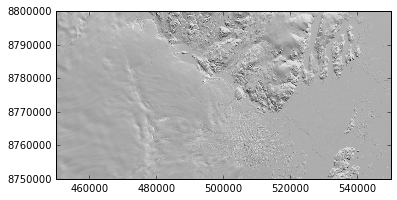

In [39]:
ls8_small = ls8.resize((450000, 8750000, 550000, 8800000))
plt.imshow(ls8_small[:,:], origin="bottom", extent=ls8_small.extent, cmap=plt.cm.binary)

**Note**

When getting raster data, the array provided by slicing is not necessarily a view of the underlying data, and may be a copy instead. Modifying the array is not guaranteed to modify the raster. When the raster data must be replaced by an element-wise computation, use the `Grid.apply(func)` method, which operates in-place. The `apply` method may be chained.

```
# Example
grid.apply(lambda x: x**2) \
    .apply(np.sin) \
    .apply(lambda x: np.where(x < 0.5, grid.nodata, x))
```

This handles nodata pixels automatically. If the raster data must be replaced by arbitrary data, set it explicitly with `Grid[:,:] = ...`.

```
# Example
grid[:,:] = np.convolve(np.ones([3,3])/9.0, grid[:,:], mode='same')
```

### Creating `RegularGrid` instances

New `RegularGrid` instances are created by specifying a geotransform. The geotransform is represented by a tuple of the form
```
transform = (xll, yll, dx, dy, sx, sy)
```
where `xll` and `yll` are the coordinates of the lower left grid corner, `dx` and `dy` specify resolution, and `sx` and `sy` specify grid skew and rotation.

The following creates an empty global grid with 5 degree resolution, oriented "north-up" and "east-right", and then plots the pixel centers:

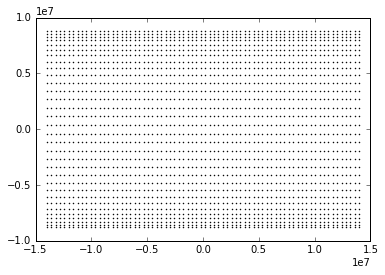

In [42]:
from karta.crs import LonLatWGS84, GallPetersEqualArea
newgrid = RegularGrid((-180, -80, 5, 5, 0, 0), values=np.zeros((160//5, 360//5)), crs=LonLatWGS84)

# visualize the coordinate positions on a Gall-Peters projection
coords = newgrid.coordinates(crs=GallPetersEqualArea)
x, y = coords[:,:]
_ = plt.plot(x, y, ".k", ms=2)

## Coordinate reference systems

TODO